<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/3_submit_test/gp-submit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submit Test

제출 형태도 정해져있으므로 Validation Set을 이용해서 제출해보기.
- Waymo에서 제공하는 Motion Prediction 튜토리얼에는 모델 학습까지만 있고 제출용 결과물을 생성하는 코드가 없음.
- 다른 challenge 튜토리얼 중 해당 부분이 존재하는 것을 확인.
  - [Waymo Open Dataset 3D Semantic Segmentation Tutorial](https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial_3d_semseg.ipynb)
- proto만 변경해서 포맷에 맞게 세팅하면 될 것 같음. 해당 코드를 보고 Motion Prediction 제출용 결과물을 만들어보고자 함.
  - [motion_submission.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/src/waymo_open_dataset/protos/motion_submission.proto)

## GCS(Google Cloud Stoarge)에서 Google Drive로 데이터셋 다운받기

google drive를 먼저 colab에 연동한 뒤, 해당 디렉토리에 GCS로부터 데이터셋 다운받기

In [ ]:
# GCS에 접근하기 위해 인증

from google.colab import auth
auth.authenticate_user()

In [ ]:
# GCS 데이터 용량 확인. 전체를 다운받기에는 구글 클라우드로 감당이 안될듯.
!gsutil ls -l "gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/" | xargs -I{} gsutil du -sh  {}

0 B          gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/lidar
645.92 GiB   gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/scenario
1.08 TiB     gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/tf_example


In [ ]:
# 라이다 데이터 validation set만 확인
!gsutil du -ch -s "gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/lidar/validation"

200.35 GiB   gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/lidar/validation
200.35 GiB   total


In [ ]:
# 시나리오 데이터 validation set만 확인
!gsutil du -ch -s "gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/scenario/validation"

38.4 GiB     gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/scenario/validation
38.4 GiB     total


데이터셋을 저장할 Google Drive를 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 구글 드라이브 위치. 마운트 잘 됐는지 확인.
GDRIVE_WOD_PATH = "/content/drive/MyDrive/waymo-od-dataset/motion_v_1_2_0/uncompressed"

!ls -al {GDRIVE_WOD_PATH}

total 12
drwx------ 2 root root 4096 Apr 14 03:28 .ipynb_checkpoints
drwx------ 3 root root 4096 Apr 14 00:03 lidar
drwx------ 2 root root 4096 Mar 29 06:17 tf_example


GCS로부터 데이터셋을 다운로드. 라이다 데이터도 다운받으려고 했는데 몇시간 기다리다가 지쳐서 일단 보류. 당장 필요한 시나리오 데이터만 우선 받아본다

In [ ]:
# 시나리오 데이터 다운로드

%%time
%%capture

!mkdir {GDRIVE_WOD_PATH}/scenario

!gsutil -m cp -r \
  "gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/scenario/validation" \
  {GDRIVE_WOD_PATH}/scenario/

CPU times: user 6.6 s, sys: 1.27 s, total: 7.86 s
Wall time: 12min 1s


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

## 환경세팅

In [2]:
%%capture

!pip3 install --upgrade pip
!pip install waymo-open-dataset-tf-2-11-0==1.5.1 # 최신 버전으로 한 번 해볼까나?

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# 마운트 확인
GDRIVE_WOD_PATH = "/content/drive/MyDrive/waymo-od-dataset/motion_v_1_2_0/uncompressed"
VALIDSET_PATH   = GDRIVE_WOD_PATH + "/scenario/validation"

!ls -al {VALIDSET_PATH} | wc -l

Mounted at /content/drive
151


## 데이터셋 로드

In [4]:
import glob

# 로컬 디렉토리에 저장된 TFRecord 파일들의 경로 리스트 생성
file_paths = glob.glob(VALIDSET_PATH + "/*.tfrecord*")
len(file_paths)

150

In [5]:
import tensorflow as tf

# TFRecordDataset 클래스를 사용하여 데이터를 읽어들임
dataset = tf.data.TFRecordDataset(file_paths, compression_type='')

In [6]:
# 데이터셋 한 개만 읽어보기
from waymo_open_dataset.protos import scenario_pb2

for data in dataset:
  scenario = scenario_pb2.Scenario()
  scenario.ParseFromString(bytearray(data.numpy()))
  break

scenario.scenario_id

'a3cfb7f093ccd29'

## motion_submission import 및 metadata 채워보기


- [motion_submission.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/src/waymo_open_dataset/protos/motion_submission.proto) 참고

```
// A set of ScenarioPredictions protos. A ScenarioPredictions proto for each
// example in the test or validation set must be included for a valid
// submission.
message MotionChallengeSubmission {
  enum SubmissionType {
    UNKNOWN = 0;

    // A submission for the Waymo open dataset motion prediction challenge.
    MOTION_PREDICTION = 1;

    // A submission for the Waymo open dataset interaction prediction challenge.
    INTERACTION_PREDICTION = 2;
  }

  // This must be set as the full email used to register at waymo.com/open.
  optional string account_name = 3;

  // This name needs to be short, descriptive and unique. Only the latest result
  // of the method from a user will show up on the leaderboard.
  optional string unique_method_name = 4;

  // Author information.
  repeated string authors = 5;
  optional string affiliation = 6;

  // A brief description of the method.
  optional string description = 7;

  // Link to paper or other link that describes the method.
  optional string method_link = 8;

  // The challenge submission type.
  optional SubmissionType submission_type = 2;

  // Set this to true if your model uses the lidar data provided in the motion
  // dataset.
  optional bool uses_lidar_data = 9;

  // The set of scenario predictions to evaluate. One entry should exist for
  // every record in the test set.
  repeated ChallengeScenarioPredictions scenario_predictions = 1;
}
```

In [7]:
from waymo_open_dataset.protos import motion_submission_pb2

submission = motion_submission_pb2.MotionChallengeSubmission()

submission.account_name = 'dlwotmd1998@gmail.com'
submission.unique_method_name = 'JSNet'
submission.authors.append('Jaeseung Lee')
submission.authors.append('Hyojin Lee')
submission.affiliation = 'RO:AD'
submission.description = "Validation Set Test"
submission.method_link = 'NA'
submission.submission_type = submission.MOTION_PREDICTION
submission.uses_lidar_data = False
submission.scenario_predictions # 이 부분이 실제 예측 값을 넣는 부분

submission

submission_type: MOTION_PREDICTION
account_name: "dlwotmd1998@gmail.com"
unique_method_name: "JSNet"
authors: "Jaeseung Lee"
authors: "Hyojin Lee"
affiliation: "RO:AD"
description: "Validation Set Test"
method_link: "NA"
uses_lidar_data: false

## prediction 결과를 담는 구조 파악해보기

- 이제 **ChallengeScenarioPredictions[ ]** 자료형의 **scenario_predictions**를 채워주면 된다.

```
// A set of predictions for a single scenario.
message ChallengeScenarioPredictions {
  // The unique ID of the scenario being predicted. This ID must match the
  // scenario_id field in the test or validation set tf.Example or scenario
  // proto corresponding to this set of predictions.
  optional string scenario_id = 1;

  // The predictions for the scenario. For the motion prediction challenge,
  // populate the predictions field. For the interaction prediction challenge,
  // populate the joint_predictions_field.
  oneof prediction_set {
    // Single object predictions. This must be populated for the motion
    // prediction challenge.
    // 우리는 요거!!
    PredictionSet single_predictions = 2;

    // Joint predictions for the interacting objects. This must be populated for
    // the interaction prediction challenge.
    JointPrediction joint_prediction = 3;
  }
}
```

- **prediction_set**은 motion prediction challenge 이기 때문에 single_predictions를 선택한다
- single_predictions은 **PredictionSet** 자료형을 가진다

```
message PredictionSet {
  // A list of predictions for the required objects in the scene. These must
  // exactly match the objects in the tracks_to_predict field of the test
  // scenario or tf.Example.
  repeated SingleObjectPrediction predictions = 1;
}
```

```
message SingleObjectPrediction {
  // The ID of the object being predicted. This must match the object_id field
  // in the test or validation set tf.Example or scenario proto corresponding to
  // this prediction. Note this must be the same as the object_id in the
  // scenario track or the state/id field in the tf.Example, not the track
  // index.
  optional int32 object_id = 1;

  // A set of up to 6 trajectory predictions for this object with varying
  // confidences. Any predictions past the first six will be discarded.
  repeated ScoredTrajectory trajectories = 2;
}
```

```
message ScoredTrajectory {
  // The object predicted trajectory.
  optional Trajectory trajectory = 1;

  // An optional confidence measure for this joint prediction. These confidence
  // scores should reflect confidence in the existence of the trajectory across
  // scenes, not normalized within a scene or per-agent.
  optional float confidence = 2;
}
```

```
message Trajectory {
  // The predicted trajectory positions.
  // For the Waymo prediction challenges, these fields must be exactly
  // length 16 - 8 seconds with 2 steps per second starting at timestamp 1.5
  // (step 15) in the scenario.
  // IMPORTANT: For the challenges, the first entry in each of these fields must
  // correspond to time step 15 in the scenario NOT step 10 or 11 (i.e. the
  // entries in these fields must correspond to steps 15, 20, 25, ... 85, 90 in
  // the scenario).
  repeated float center_x = 2 [packed = true];
  repeated float center_y = 3 [packed = true];
}
```

- 드디어 실제 좌표값을 담는 부분까지 찾았다. 이제 내용을 담아 submission 결과물을 만들어본다

## Validation 내 내용을 그대로 제출해보기

In [16]:
import glob
import tensorflow as tf

GDRIVE_WOD_PATH = "/content/drive/MyDrive/waymo-od-dataset/motion_v_1_2_0/uncompressed"
VALIDSET_PATH   = GDRIVE_WOD_PATH + "/scenario/validation"

file_paths = glob.glob(VALIDSET_PATH + "/*.tfrecord*")
print(len(file_paths))

dataset = tf.data.TFRecordDataset(file_paths, compression_type='')

150


In [17]:
from waymo_open_dataset.protos import motion_submission_pb2

submission = motion_submission_pb2.MotionChallengeSubmission()

submission.account_name = 'dlwotmd1998@gmail.com'
submission.unique_method_name = 'JSNet'
submission.authors.extend(['Jaeseung Lee', 'Hyojin Lee'])
submission.affiliation = 'RO:AD'
submission.description = "Validation Set Test"
submission.method_link = 'NA'
submission.submission_type = submission.MOTION_PREDICTION
submission.uses_lidar_data = False

submission

submission_type: MOTION_PREDICTION
account_name: "dlwotmd1998@gmail.com"
unique_method_name: "JSNet"
authors: "Jaeseung Lee"
authors: "Hyojin Lee"
affiliation: "RO:AD"
description: "Validation Set Test"
method_link: "NA"
uses_lidar_data: false

In [18]:
%%time

from waymo_open_dataset.protos import scenario_pb2

cnt = 1
for data in dataset:
  if cnt % 10000 == 0:
    print(f"** Scenario {cnt}")
  cnt += 1
  
  scenario = scenario_pb2.Scenario()
  scenario.ParseFromString(bytearray(data.numpy()))

  if len(scenario.tracks_to_predict) == 0:
    continue

  scenario_preds = motion_submission_pb2.ChallengeScenarioPredictions()
  scenario_preds.scenario_id = scenario.scenario_id

  for ttp in scenario.tracks_to_predict:
    track = scenario.tracks[ttp.track_index]
    prediction = motion_submission_pb2.SingleObjectPrediction()
    prediction.object_id = track.id

    scored_trajectory = motion_submission_pb2.ScoredTrajectory()

    # 예측해야하는 답안. future. 8초간 0.5초씩 총 16개의 (x,y)를 예측
    # 시작 지점은 15번째부터.
    future_states = track.states[15::5]
    for state in future_states:
      scored_trajectory.trajectory.center_x.append(state.center_x)
      scored_trajectory.trajectory.center_y.append(state.center_y)
    prediction.trajectories.append(scored_trajectory)

    scenario_preds.single_predictions.predictions.append(prediction)

  submission.scenario_predictions.append(scenario_preds) # submission에 추가하기

print(f"** Scenario {cnt}")

** Scenario 10000
** Scenario 20000
** Scenario 30000
** Scenario 40000
** Scenario 44098
CPU times: user 22min 15s, sys: 28.7 s, total: 22min 44s
Wall time: 25min 5s


- 약 20분정도 걸림 (동적으로 데이터셋 로드하고 해제하다보니 반복이 느림)

In [19]:
import tarfile
from time import time
import io
from google.colab import files

timestamp = str(time()).split('.')[0]
fname = f'result-{timestamp}.tar.gz'

# submission 파일의 형태는 bin이지만, tarball(tar.gz)로 압축해서 제출해야 함.
with tarfile.open(fname, "w:gz") as tar:
    f = io.BytesIO(submission.SerializeToString())
    info = tarfile.TarInfo(name=fname)
    info.size = len(f.getvalue())
    tar.addfile(tarinfo=info, fileobj=f)

files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

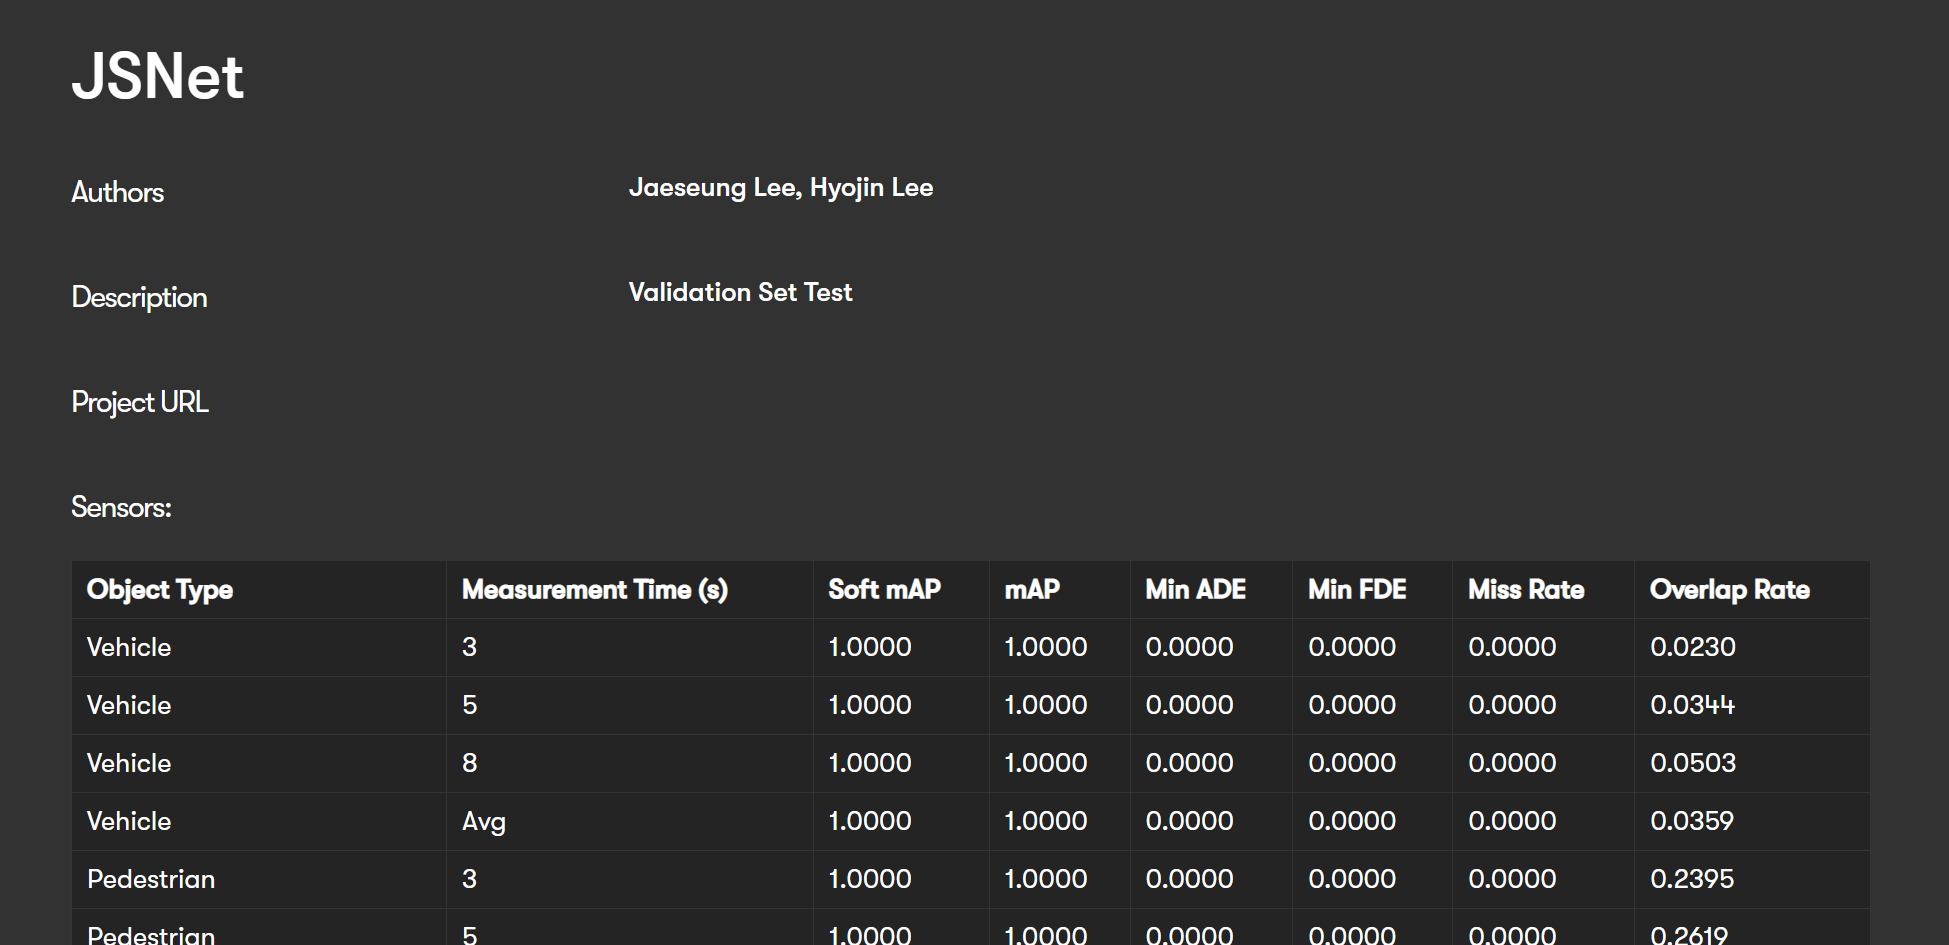

## 기타

**Waymo 제출 시 메세지 정리**
- This submission could not be found. If it was recently uploaded, it may still be processing. Check back in a few minutes.
  - 업로드 한 직후 뜨는 메세지. 상황에 따라 다르지만 최소 15분정도 소요된다. 15분동안 다른 일 보다가 돌아오자.
- INVALID_ARGUMENT
  - INVALID_ARGUMENT: Not enough scenario predictions in submission : {숫자}
    - 시나리오 몇개 빼먹었을 때. 처음에 너무 오래걸려서 for문에 break 넣었다가 맞이한 오류
  - INVALID_ARGUMENT: Duplicate prediction scenario ID found : {시나리오 ID}
    - 중복된 시나리오가 존재할 때. 중복이 발생한 원인 찾는게 머리아픔,,
- CANCELLED
  - CANCELLED: Invalid predicted trajectory length. Expected : 16 found : 0 trajectory : object_id: 1315
    - 예측해야 할 trajectory인 16개가 충족되지 않은 경우. found 다음에 오는 숫자가 문제되는 부분이다. 16개의 궤적이 들어가야 하지만 내 데이터에는 0개라는 뜻.
  - CANCELLED: Invalid predicted trajectory length. Expected : 16 found : 1 trajectory : object_id: 3039 center_x: -2903.2134 center_y: -8315.674
    - 위와 마찬가지다. 이번에는 center_x가 array인데 여기에 16개를 넣지 않고 1개만 넣어서 발생.

In [ ]:
# tutorial/3_submit_test/gp-submit_test.ipynb